In [109]:
import pandas as pd
import joblib
import os
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from scipy.stats import randint, uniform

def fit_unified_model(data_path="../data/raw/full_data.csv", model_path="../models/denoise_adaboost/adaboost_model.pkl"):
    df = pd.read_csv(data_path)

    X = df[["porosity", "T", "strainrate", "strain"]]
    y = df["stress"]

    # Hyperparameters range 
    # For denoising only, I prefer a little bit overfitting than underfitting
    param_dist = {
        "n_estimators": randint(20, 100),
        "learning_rate": uniform(0.05, 0.4),
        "estimator__max_depth": randint(25, 65)
    }

    base_model = AdaBoostRegressor(
        estimator=DecisionTreeRegressor(),
        random_state=42
    )

    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=40,
        cv=5,
        scoring="neg_mean_absolute_error",
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    search.fit(X, y)
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    joblib.dump(search.best_estimator_, model_path)

    # Compute MAE on training set
    y_pred = search.best_estimator_.predict(X)
    mae = mean_absolute_error(y, y_pred)

    # Save metrics to CSV
    para_mae_df = pd.DataFrame([{
        "MAE": round(mae, 2),
        "n_estimators": search.best_params_["n_estimators"],
        "learning_rate": round(search.best_params_["learning_rate"], 2),
        "max_depth": search.best_params_["estimator__max_depth"]
    }])

    para_mae_path = "../models/denoise_adaboost/baseline_mae_paras.csv"
    para_mae_df.to_csv(para_mae_path, index=False)

fit_unified_model()

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [100]:
import numpy as np
import joblib

# Search tree from research_tree.py
layer1 = np.array([0, 26, 36])

layer2 = np.array([
    [20, 200, 400],
    [25, 100, 200, 300],
    [25, 100, 300]
], dtype=object)

layer3 = np.array([
    [[500, 1000, 3000, 5000], [500, 3000], [500, 3000]],
    [[1200, 2300, 3600, 5200], [950, 2200, 3000, 4200],
     [1050, 1500, 1950, 2800, 3800], [1100, 1900, 2900, 3700]],
    [[1000, 2000, 3000], [1300, 2050, 2350, 3400, 3700],
     [1000, 2000, 3000, 4000, 4500]]
], dtype=object)

def find_bounds(target, candidates):
    candidates = np.array(candidates)
    if target <= candidates[0]:
        return candidates[0], candidates[0]
    if target >= candidates[-1]:
        return candidates[-1], candidates[-1]
    for i in range(len(candidates) - 1):
        if candidates[i] <= target <= candidates[i+1]:
            return candidates[i], candidates[i+1]
    raise ValueError(f"Cannot find bounds for {target} in {candidates}")

def predict_stress_strain_hai(porosity, T, rate, strain_step=0.001,
                              model_path="../models/denoise_adaboost/adaboost_model.pkl"):
    strain_range = np.arange(0, 0.25, strain_step)
    model = joblib.load(model_path)

    # 1. porosity bounds
    p0, p1 = find_bounds(porosity, layer1)

    # 2. temperature bounds at each porosity
    t0_p0, t1_p0 = find_bounds(T, layer2[np.where(layer1 == p0)[0][0]])
    t0_p1, t1_p1 = find_bounds(T, layer2[np.where(layer1 == p1)[0][0]])

    # 3. strainrate bounds at each (p, T)
    def get_r_bounds(p, t):
        i = np.where(layer1 == p)[0][0]
        j = np.where(layer2[i] == t)[0][0]
        return find_bounds(rate, layer3[i][j])

    r0_p0t0, r1_p0t0 = get_r_bounds(p0, t0_p0)
    r0_p0t1, r1_p0t1 = get_r_bounds(p0, t1_p0)
    r0_p1t0, r1_p1t0 = get_r_bounds(p1, t0_p1)
    r0_p1t1, r1_p1t1 = get_r_bounds(p1, t1_p1)

    def predict(p, t, r):
        strain_range = np.arange(0, 0.25, strain_step)
        X = pd.DataFrame({
            "porosity": p,
            "T": t,
            "strainrate": r,
            "strain": strain_range
        })
        return model.predict(X)

    def interp(c0, c1, alpha):
        return (1 - alpha) * c0 + alpha * c1

    # Step 1: interpolate strainrate
    c_p0_t0 = interp(predict(p0, t0_p0, r0_p0t0), predict(p0, t0_p0, r1_p0t0), (rate - r0_p0t0) / (r1_p0t0 - r0_p0t0 + 1e-8))
    c_p0_t1 = interp(predict(p0, t1_p0, r0_p0t1), predict(p0, t1_p0, r1_p0t1), (rate - r0_p0t1) / (r1_p0t1 - r0_p0t1 + 1e-8))
    c_p1_t0 = interp(predict(p1, t0_p1, r0_p1t0), predict(p1, t0_p1, r1_p1t0), (rate - r0_p1t0) / (r1_p1t0 - r0_p1t0 + 1e-8))
    c_p1_t1 = interp(predict(p1, t1_p1, r0_p1t1), predict(p1, t1_p1, r1_p1t1), (rate - r0_p1t1) / (r1_p1t1 - r0_p1t1 + 1e-8))

    # Step 2: temperature
    alpha_t_p0 = (T - t0_p0) / (t1_p0 - t0_p0 + 1e-8)
    alpha_t_p1 = (T - t0_p1) / (t1_p1 - t0_p1 + 1e-8)
    c_p0 = interp(c_p0_t0, c_p0_t1, alpha_t_p0)
    c_p1 = interp(c_p1_t0, c_p1_t1, alpha_t_p1)

    # Step 3: porosity
    alpha_p = (porosity - p0) / (p1 - p0 + 1e-8)
    final_curve = interp(c_p0, c_p1, alpha_p)

    return strain_range, final_curve

In [105]:
import matplotlib.pyplot as plt

def plot_curve(porosity, T, rate, strain_step=0.001,
               model_path="../models/denoise_adaboost/adaboost_model.pkl"):
    strains, preds = predict_stress_strain_hai(porosity, T, rate, strain_step, model_path)
    plt.figure(figsize=(6, 4))
    plt.plot(strains, preds, label=f"porosity={porosity}, T={T}, rate={rate}")
    plt.xlabel("Strain")
    plt.ylabel("Stress (MPa)")
    plt.title("Stress-Strain Curve (Interpolation)")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

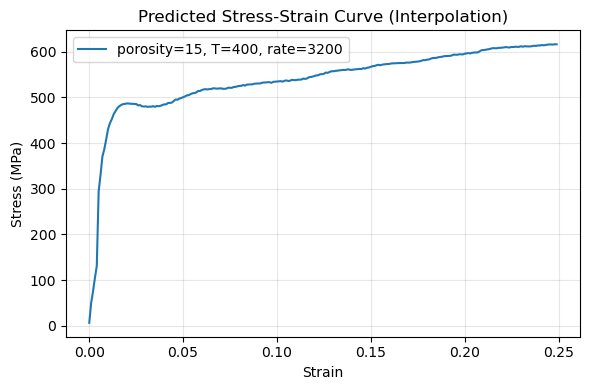

In [108]:
# test
plot_curve(porosity=15, T=400, rate=3200)